# Retinanet Model (FPN + Focal Loss)

In [0]:
import numpy as np
import keras
import tensorflow as tf
from keras.models import Model, Sequential
from keras.layers import Dense, Dropout, Flatten, Input, AveragePooling2D, merge, Activation, Add
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization,Reshape
from keras.layers import Concatenate
from keras.optimizers import Adam
from keras import backend as K

import math

Using TensorFlow backend.


## Hyperparameters

In [0]:
input_image_size = [None,None,3]
num_classes=20
include_top= False #False= Mutiple enconding o/p, True:classification o/p
pyramid_network_filters=256
data_format='channels_last'
regression_filter=256
classification_filter=256
prior_prob = 0.01
class_specific_filter = False 
max_detections=10
score_threshold=0.05
iou_threshold=0.5
parallel_iterations=1
learning_rate=1e-5

#Basic Anchors parameters
sizes   = np.array([32.0, 64.0, 128.0, 256.0, 512.0], K.floatx())
strides = np.array([8.0, 16.0, 32.0, 64.0, 128.0], K.floatx())
ratios  = np.array([0.5, 1, 2], K.floatx())
scales  = np.array([2 ** 0, 2 ** (1.0 / 3.0), 2 ** (2.0 / 3.0)], K.floatx())


In [0]:
num_anchors = len(ratios) * len(scales) #9


## Resnet50 Model

In [0]:
!pip install keras-resnet
import keras_resnet
import keras_resnet.models




  Running setup.py bdist_wheel for keras-resnet ... - done
  Stored in directory: /root/.cache/pip/wheels/80/dd/ac/842235b63dddac12faa4b48ebe58b8944e8c2e57c2e38dddb6
Successfully built keras-resnet


######Sub-level *testing* of resnet50

In [0]:
# def resnet50_model(input_image_size,num_classes,include_top ):
#   x = keras.layers.Input(input_image_size)
#   #print (x.output_shape)
#   resnet50 = keras_resnet.models.ResNet50(x, classes=num_classes,include_top=include_top)
  
#   for layer in resnet50.layers:
#     layer.trainable=Resnet_trainable
    
#   print("Trainable:-",resnet50.layers[1].trainable)

#   backbone_layers= resnet50.outputs[1:]
#   print ("\n backbone_Layers[C3-C5]:-",backbone_layers)
  
#   resnet50.summary()
  
#   return backbone_layers

# bl=resnet50_model(input_image_size,num_classes,include_top)
# bl #backbonelayers

##Retinanet Model (Resnet50 as Backbone)

#####Feature Pyramid Network

In [0]:
def Feature_Pyramid_Network(backbone_layers,pyramid_network_filters):
  [C3,C4,C5]=backbone_layers #(batch,height,width,channel)
  
  C3_height   = K.shape(C3)[1] 
  C3_width    = K.shape(C3)[2]
  C4_height   = K.shape(C4)[1]
  C4_width    = K.shape(C4)[2]
  
 
  P5          = Conv2D( kernel_size=1,   filters=pyramid_network_filters,   strides=1,   padding='same',   data_format=data_format) (C5)
  P5_Upscale  = keras.layers.Lambda( lambda image1: tf.image.resize_images(P5, (C4_height,C4_width), method = tf.image.ResizeMethod.NEAREST_NEIGHBOR)) (P5)
  P5          = Conv2D( kernel_size=3,   filters=pyramid_network_filters,   strides=1,   padding='same',   data_format=data_format, name='P5') (P5)
  
  P4          = Conv2D( kernel_size=1,   filters=pyramid_network_filters,   strides=1,   padding='same',   data_format=data_format) (C4)
  P4          = keras.layers.Add() ([P4,P5_Upscale])
  P4_Upscale  = keras.layers.Lambda( lambda image2: tf.image.resize_images(P4, (C3_height,C3_width), method = tf.image.ResizeMethod.NEAREST_NEIGHBOR)) (P4)
  P4          = Conv2D( kernel_size=3,   filters=pyramid_network_filters,   strides=1,   padding='same',   data_format=data_format, name='P4') (P4)
  
  P3          = Conv2D( kernel_size=1,   filters=pyramid_network_filters,   strides=1,   padding='same',   data_format=data_format) (C3)
  P3          = keras.layers.Add() ([P3,P4_Upscale])
  P3          = Conv2D( kernel_size=3,   filters=pyramid_network_filters,   strides=1,   padding='same',   data_format=data_format, name='P3') (P3)
  
  P6          = Conv2D( kernel_size=3,   filters=pyramid_network_filters,   strides=2,   padding='same',   data_format=data_format, name='P6') (P5)
  
  P6_relu     = Activation('relu') (P6)
  P7          = Conv2D( kernel_size=3,   filters=pyramid_network_filters,   strides=2,   padding='same',   data_format=data_format, name='P7') (P6_relu)
  
  
  return [P3, P4, P5, P6, P7]

######sub-level testing of feature pyramid network

In [0]:
# bl #backbonelayers
# g2=Feature_Pyramid_Network(backbone_layers= bl , pyramid_network_filters=pyramid_network_filters)
# g2


#####Subnet_model = Regression + Classification Model

In [0]:
def regression(pyramid_network_filters, regression_filter,num_anchors):
  feature_map=     Input(shape =(None,None,pyramid_network_filters))
  
  Reg1=            Conv2D( kernel_size=3,   filters=regression_filter,   strides=1,   padding='same', activation='relu' ,data_format=data_format, 
                         kernel_initializer=keras.initializers.normal(mean=0.0, stddev=0.01, seed=None), bias_initializer='zeros') (feature_map)
  Reg2=            Conv2D( kernel_size=3,   filters=regression_filter,   strides=1,   padding='same', activation='relu' ,data_format=data_format,
                         kernel_initializer=keras.initializers.normal(mean=0.0, stddev=0.01, seed=None), bias_initializer='zeros') (Reg1)
  Reg3=            Conv2D( kernel_size=3,   filters=regression_filter,   strides=1,   padding='same', activation='relu' ,data_format=data_format,
                         kernel_initializer=keras.initializers.normal(mean=0.0, stddev=0.01, seed=None), bias_initializer='zeros') (Reg2)
  Reg4=            Conv2D( kernel_size=3,   filters=regression_filter,   strides=1,   padding='same', activation='relu' ,data_format=data_format,
                         kernel_initializer=keras.initializers.normal(mean=0.0, stddev=0.01, seed=None), bias_initializer='zeros') (Reg3)
  
  Reg_subnet_out=  Conv2D( kernel_size=3,   filters= 4 *num_anchors ,   strides=1,   padding='same',   data_format=data_format,
                         kernel_initializer=keras.initializers.normal(mean=0.0, stddev=0.01, seed=None), bias_initializer='zeros',name='regression_output') (Reg4)
  
  #Covert Shape=[Batch, W,H, 4*num_anchors] --> [Batch,Anchors,4]
  #4D to 3D shape
  Reg_subnet_out=  Reshape((-1, 4), name='Regression_reshape') (Reg_subnet_out) 
  
  return keras.models.Model(inputs=feature_map,outputs=Reg_subnet_out,name='Regression_subnet') #[Batch,Anchors,4]
  

In [0]:
def classification(pyramid_network_filters, num_classes,classification_filter,num_anchors):
  
  bias_init =        - math.log((1 - prior_prob) / prior_prob)     #b = − log((1 − π)/π)
  
  feature_map =      Input(shape =(None,None,pyramid_network_filters))
  
  class1=            Conv2D( kernel_size=3,   filters=classification_filter,   strides=1,   padding='same', activation='relu' ,data_format=data_format,
                           kernel_initializer=keras.initializers.normal(mean=0.0, stddev=0.01, seed=None), bias_initializer='zeros') (feature_map)
  class2=            Conv2D( kernel_size=3,   filters=classification_filter,   strides=1,   padding='same', activation='relu' ,data_format=data_format,
                           kernel_initializer=keras.initializers.normal(mean=0.0, stddev=0.01, seed=None), bias_initializer='zeros') (class1)
  class3=            Conv2D( kernel_size=3,   filters=classification_filter,   strides=1,   padding='same', activation='relu' ,data_format=data_format,
                           kernel_initializer=keras.initializers.normal(mean=0.0, stddev=0.01, seed=None), bias_initializer='zeros') (class2)
  class4=            Conv2D( kernel_size=3,   filters=classification_filter,   strides=1,   padding='same', activation='relu' ,data_format=data_format,
                           kernel_initializer=keras.initializers.normal(mean=0.0, stddev=0.01, seed=None), bias_initializer='zeros') (class3)
  
  class_subnet_out= Conv2D( kernel_size=3,  filters= num_classes*num_anchors ,   strides=1,   padding='same',   data_format=data_format,
                          kernel_initializer=keras.initializers.normal(mean=0.0, stddev=0.01, seed=None),
                          bias_initializer= keras.initializers.Constant(value=bias_init),name='classification_output' )    (class4) 
  
  #Covert Shape=[Batch, W,H, 4*num_classes] --> [Batch,Anchors,num_classes]
  #4D to 3D shape
  class_subnet_out = Reshape((-1, num_classes), name='classification_reshape')(class_subnet_out)
  class_subnet_out = Activation('sigmoid', name='classification_sigmoid')(class_subnet_out)
  
  return keras.models.Model(inputs=feature_map, outputs=class_subnet_out, name='Classification_subnet')#[Batch,Anchors,num_classes]

In [0]:
def subnet_models(pyramid_network_filters, num_classes,regression_filter,classification_filter,num_anchors):
  return ([regression(pyramid_network_filters, regression_filter,num_anchors),
       classification(pyramid_network_filters, num_classes,regression_filter,num_anchors)]
         )

######Sub-level testing of subnet_models

In [0]:
# sub1= subnet_models(pyramid_network_filters, num_classes,regression_filter,classification_filter,num_anchors)

# for M1 in sub1:
#   print ("\n",  M1 , "\n" + "\n")
#   M1.summary()

####Retinanet Model

In [0]:
def retinanet_model(input_image_size,include_top, pyramid_network_filters,num_classes,regression_filter,classification_filter,num_anchors):
  
  # Resnet50 model with trainable50 as backbone layers   
  x = keras.layers.Input(input_image_size)
  resnet50 = keras_resnet.models.ResNet50(x, classes=num_classes,include_top=include_top)
  
  backbone_layers= resnet50.outputs[1:]
  
  #Feature pyramid networks with Resnet backbone (Features)
  features = Feature_Pyramid_Network(backbone_layers=backbone_layers, pyramid_network_filters=pyramid_network_filters) # Features [P3,P4,P5,P6,P7]
  
  #connect subnet to each feature pyramid layer/map
  models=subnet_models(pyramid_network_filters, num_classes,regression_filter,classification_filter,num_anchors)
  
  regression     = keras.layers.Concatenate(axis=1,name='Subnets_Regression')    ([models[0](feature) for feature in features]) #model[0] = regression_model
  classification = keras.layers.Concatenate(axis=1,name='Subnets_Classification')([models[1](feature) for feature in features]) #model[1] = classfication_model
  
  return keras.models.Model(inputs=x, outputs=[regression,classification],name='Retinanet')

######Sub-level *testing* of retinanet model

In [0]:
retinanet = retinanet_model(input_image_size,include_top, pyramid_network_filters,num_classes,regression_filter,classification_filter,num_anchors)
retinanet.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
padding_conv1 (ZeroPadding2D)   (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, None, None, 6 9408        padding_conv1[0][0]              
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, None, None, 6 256         conv1[0][0]                      
__________________________________________________________________________________________________
conv1_relu

######Sub-level testing of Retinanet Model

In [0]:
#s = input_image_size
#my=keras.models.Model( inputs=[None,None,3], outputs= retinanet_model([None,None,3],include_top,pyramid_network_filters,num_classes,regression_filter,classification_filter,num_anchors) )
#my_summary()
#backbone_layers=resnet50_model(input_image_size,num_classes,include_top)
#t=  retinanet_model(input_image_size,include_top, pyramid_network_filters,num_classes,regression_filter,classification_filter,num_anchors)
#t.summary()



##Retinanet box(Wrapper of Retinanet for object detection)

#####Generate Anchors

In [0]:
def basic_anchor(size,ratios,scales,num_anchors):
  # Generate basic anchors(=num_anchors) based on ratio+scales for each SIZE
  
  #scaled height & Width
  scaled_size= np.array([size * scale for scale in scales])
  
  heights = scaled_size
  widths  = scaled_size
  
  
  #Apply ratio on H & W  
  heights = np.array( [ heights*np.sqrt(ratio)   for ratio in ratios] ) # H = H * 1/sqrt(ratio)
  widths = np.array( [  widths*np.sqrt(1/ratio)  for ratio in ratios] )  # W = W * sqrt(ratio)
   
  
  heights= np.reshape(heights,(num_anchors) ) #shape=(num_anchors,)
  widths = np.reshape(widths, (num_anchors) )
  # convert (x,y,h,w) to (x1,y1,x2,y2)  
  x1= -(widths)/2
  x2= widths/2
  y1= -(heights)/2
  y2= heights/2
  
  basic_anchors=np.transpose(np.array([x1,y1,x2,y2]))   # (4,num_anchors)-->(num_anchors,4)
  return basic_anchors #(x1,y1,x2,y2) , shape=(num_anchors,4) 
  
  

In [0]:
def shifted_anchor(basic_anchors,num_anchors,feature,stride):  
  
  import tensorflow
  
  height_feature = feature[0]
  width_feature  = feature[1]
  
   
  shift_y = (K.arange(0, height_feature, dtype=K.floatx()) + K.constant(0.5, dtype=K.floatx())) * stride
  shift_x = (K.arange(0, width_feature,  dtype=K.floatx()) + K.constant(0.5, dtype=K.floatx())) * stride

  shift_x, shift_y = meshgrid(shift_x, shift_y) # shape=(W_f , H_f)  #Check
  shift_x = K.reshape(shift_x, [-1]) # shape= W_f * H_f  
  shift_y = K.reshape(shift_y, [-1]) 
  
 
  shifts = K.stack([shift_x,shift_y,shift_x,shift_y], axis=0)   #packed along axis=0 , shape=[4, W_f * H_f ]

  shifts            = K.transpose(shifts) #shape=[ W_f * H_f  ,4 ]

  pixel_num = K.shape(shifts)[0]  # Total pixel ,K = W_f * H_f
  
  #Objective apply basic anchors on each pixel/point of feature map
  # [1,9,4] + [pixel,1,4] -> [pixel_num ,9,4] -> [pixel_num *9,4]   assuming 9=No. of basic anchors             
  shifted_anchor = K.reshape(basic_anchors, [1, num_anchors, 4]) + K.cast(K.reshape(shifts, [pixel_num, 1, 4]), K.floatx())
  shifted_anchor = K.reshape(shifted_anchor, [pixel_num * num_anchors, 4])
  
 
  return shifted_anchor # shape = [pixel_num *9,4]

In [0]:
class feature_anchors(keras.layers.Layer):
  def __init__(self, size, stride, ratios=None, scales=None,*args,**kwargs):
    self.size   = size
    self.stride = stride
    self.ratios = ratios
    self.scales = scales
    self.num_anchors = len(ratios) * len(scales)
    self.anchors     = keras.backend.variable(basic_anchor(
        size=size,
        ratios=ratios,
        scales=scales,
        num_anchors=num_anchors,
    ))
    super(feature_anchors, self).__init__(*args, **kwargs)
    
  def call(self, inputs,**kwargs):
    feature = inputs
    feature_shape = keras.backend.shape(feature)
    shifted_anchors = shifted_anchor(self.anchors,num_anchors,feature_shape[1:3], self.stride) #shape = [pixel_num *9,4] = [shifted_anchor,4 ]   9=basic anchors
    shifted_anchors = K.tile(K.expand_dims(shifted_anchors, axis=0), (feature_shape[0], 1, 1))# Add Batch_size factor
    return shifted_anchors
  
  def compute_output_shape(self, input_shape):
    if None not in input_shape[1:]:
      total = np.prod(input_shape[1:3]) * self.num_anchors        

      return (input_shape[0], total, 4)
    else:
      return (input_shape[0], None, 4)
    

    

def generate_anchors(features,sizes,strides,ratios,scales,num_anchors):
  anchors= [feature_anchors(sizes[i],strides[i],ratios,scales,name='anchors_{}'.format(i)) (feature) for i,feature in enumerate (features) ] #shape=[batch,feature_num,shited_anchors,4]
  return keras.layers.Concatenate(axis=1, name='anchors')(anchors) #shape=[batch, feature_num*shited_anchors ,4] = [batch, Anchors, 4]
  

#####Regression & Clip Boxes

In [0]:
class regressionbox(keras.layers.Layer):
  
  def compute_output_shape(self, input_shape):
    return input_shape[0]
  
  def call(self,inputs):
    anchors=inputs[0]
    deltas=inputs[1]
    
    mean = [0, 0, 0, 0]
    std = [0.2, 0.2, 0.2, 0.2]
  
    #deltas factor of width & height  
    width = anchors[:,:,2] - anchors[:,:,0]  # W = x2 - x1
    height= anchors[:,:,3] - anchors[:,:,1]  # H = y2 - y1
  
    # 'Tensor' object does not support item assignment, So build list & stack
  
    #shape(batch,Anchors)
    x1=anchors[:,:,0] + width  * (deltas[:,:,0] * std[0] + mean[0]) #denormalized deltas bcz of generator logic,we get normalized detla as input here 
    y1=anchors[:,:,1] + height * (deltas[:,:,1] * std[1] + mean[1])
    x2=anchors[:,:,2] + width  * (deltas[:,:,2] * std[2] + mean[2])
    y2=anchors[:,:,3] + height * (deltas[:,:,3] * std[3] + mean[3])
  
    predicted_boxes = K.stack([x1,y1,x2,y2],axis=2) #shape=(batch,Anchors,4)  
     
    return predicted_boxes



class clipbox(keras.layers.Layer): #clipped box/pixel value which is lying outside input image
  def compute_output_shape(self, input_shape):
    return input_shape[1]
    
  def call(self,inputs):
    boxes=inputs[0]
    image=inputs[1]
    
    image_shape= K.cast(K.shape(image), K.floatx())
    height_max = image_shape[0]
    width_max  = image_shape[1]
      
    #shape(batch,Anchors)
    x1 = clip_by_value(boxes[:, :, 0], clip_value_min=0, clip_value_max=width_max ) 
    y1 = clip_by_value(boxes[:, :, 1], clip_value_min=0, clip_value_max=height_max)
    x2 = clip_by_value(boxes[:, :, 2], clip_value_min=0, clip_value_max=width_max )
    y2 = clip_by_value(boxes[:, :, 3], clip_value_min=0, clip_value_max=height_max)
      
    predicated_cliped_boxes= K.stack([x1,y1,x2,y2],axis=2) #shape=(batch,Anchors,4) 
          
    return predicated_cliped_boxes

#####Filter Detection

In [0]:
def nms_n_score_threshold(boxes, scores, labels, max_detections, score_threshold, iou_threshold):
  #Return indices contain indexes of Anchors after score_threshold+NMS
  
   
  #Apply score_threshold + nms
  #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
  indices = where(K.greater(scores,score_threshold))#Check #shape=[X,1], X=Not fixed=Reduced_anchors; give index value for (scores>threshold) e.g. [[1][2][3]]  X=True elements
  
  filtered_boxes=gather_nd(boxes,indices)#Check #shape=[X,4]        # Reason to use gather_nd:-If we use gather here shape[X,1,4]
  filtered_scores=K.gather(scores,indices)[:,0]#shape=[X,1] --> [X]  #Reduced_anchors=Anchors whoes score > score_threshold
  
  #nms: shape=[M] ; M=Seleted Anchores/Tensors (M <= max_output_size) #Check
  nms_indices=non_max_suppression(boxes=filtered_boxes, scores=filtered_scores, max_output_size=max_detections, iou_threshold=iou_threshold) #e.g. o/p=[1 10 3]
  
  indices = K.gather(indices,nms_indices) #[M,1]
  labels = gather_nd(labels, indices) #[M] 
  indices_labels = K.stack([indices[:, 0], labels], axis=1)#shape=[M,2]
  #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
  return indices_labels 

In [0]:
def detections_logic(boxes,classification):
    
  #~~~~~~~~~nms/score_threshold based on per class based or best scoring class
  if class_specific_filter: #classification=[Anchors,num_class]
        all_indices = []
        # perform per class filtering
        for c in range(int(classification.shape[1])):
            scores = classification[:, c] #shape=[some_anchors]
            labels = c * backend.ones((keras.backend.shape(scores)[0],), dtype='int64') #shape=[some_anchors]
            all_indices.append(nms_n_score_threshold(boxes, scores, labels,max_detections,score_threshold,iou_threshold))

        # concatenate indices to single tensor
        indices_labels = k.concatenate(all_indices, axis=0)#[X,2] X>M
  else:
    scores        = K.max   (classification,axis=1) #shape=[some_anchors]
    labels        = K.argmax(classification,axis=1) #shape=[some_anchors]
    indices_labels= nms_n_score_threshold(boxes, scores, labels,max_detections,score_threshold,iou_threshold) #shape=[M,1]
    
    
    # Select Top k(max_detection)
    labels              = indices_labels[:, 1] #[X] or [M]
    scores   = gather_nd(classification, indices_labels)#Check#[X] or [M]   #shape=[X] for class_specific_filter=TRUE
                                                                         #shape=[M] for class_specific_filter=FALSE
      
    scores_k, top_indices = top_k(input=scores, k=K.minimum(max_detections, K.shape(scores)[0]))#Check #score=Rank 1, k= Rank 0  Tensor; top_k return value+indices
    #scores/top_indices = shape[k]
    
    # filter input using the final set of indices
    
    indices_k             = K.gather(indices_labels[:, 0], top_indices)#[K]
    boxes_k               = K.gather(boxes, indices_k)  #[K,4]   Where K <= Max_detection
    labels_k              = K.gather(labels, top_indices) #[K]
    
    # Zero pad at last rows
    pad_size = K.maximum(0, max_detections - K.shape(scores)[0])#PaddingSize= 0 or max_detection-K
    boxes    = pad(boxes_k, [[0, pad_size], [0, 0]], constant_values=-1) #shape[max_detections,4] #Check
    scores   = pad(scores_k, [[0, pad_size]], constant_values=-1) #shape[max_detections]
    labels   = pad(labels_k, [[0, pad_size]], constant_values=-1) #shape[max_detections]
    
    #Verify dtype
    labels   = K.cast(labels, 'int32')
    boxes    = K.cast(boxes, K.floatx())
    scores   = K.cast(scores,K.floatx())
    
    #Verify Shape
    boxes.set_shape([max_detections, 4])
    scores.set_shape([max_detections])
    labels.set_shape([max_detections])
    
    return [boxes, scores, labels]

In [0]:
import tensorflow
def map_fn(*args, **kwargs):
    """ See https://www.tensorflow.org/versions/master/api_docs/python/tf/map_fn .
    """
    return tensorflow.map_fn(*args, **kwargs)

def ones(*args, **kwargs):
    """ See https://www.tensorflow.org/versions/master/api_docs/python/tf/ones .
    """
    return tensorflow.ones(*args, **kwargs)


def transpose(*args, **kwargs):
    """ See https://www.tensorflow.org/versions/master/api_docs/python/tf/transpose .
    """
    return tensorflow.transpose(*args, **kwargs)


def map_fn(*args, **kwargs):
    """ See https://www.tensorflow.org/versions/master/api_docs/python/tf/map_fn .
    """
    return tensorflow.map_fn(*args, **kwargs)


def pad(*args, **kwargs):
    """ See https://www.tensorflow.org/versions/master/api_docs/python/tf/pad .
    """
    return tensorflow.pad(*args, **kwargs)


def top_k(*args, **kwargs):
    """ See https://www.tensorflow.org/versions/master/api_docs/python/tf/nn/top_k .
    """
    return tensorflow.nn.top_k(*args, **kwargs)


def clip_by_value(*args, **kwargs):
    """ See https://www.tensorflow.org/versions/master/api_docs/python/tf/clip_by_value .
    """
    return tensorflow.clip_by_value(*args, **kwargs)


def non_max_suppression(*args, **kwargs):
    """ See https://www.tensorflow.org/versions/master/api_docs/python/tf/image/non_max_suppression .
    """
    return tensorflow.image.non_max_suppression(*args, **kwargs)


def range(*args, **kwargs):
    """ See https://www.tensorflow.org/versions/master/api_docs/python/tf/range .
    """
    return tensorflow.range(*args, **kwargs)


def scatter_nd(*args, **kwargs):
    """ See https://www.tensorflow.org/versions/master/api_docs/python/tf/scatter_nd .
    """
    return tensorflow.scatter_nd(*args, **kwargs)


def gather_nd(*args, **kwargs):
    """ See https://www.tensorflow.org/versions/master/api_docs/python/tf/gather_nd .
    """
    return tensorflow.gather_nd(*args, **kwargs)


def meshgrid(*args, **kwargs):
    """ See https://www.tensorflow.org/versions/master/api_docs/python/tf/meshgrid .
    """
    return tensorflow.meshgrid(*args, **kwargs)


def where(*args, **kwargs):
    """ See https://www.tensorflow.org/versions/master/api_docs/python/tf/where .
    """
    return tensorflow.where(*args, **kwargs)

In [0]:
class filter_detection(keras.layers.Layer):  
   
  def call(self,inputs):
    boxes          = inputs[0]
    classification = inputs[1]
    
    def _detections_logic(args):
      boxes          = args[0]
      classification = args[1]
      return detections_logic( boxes, classification )
    
    
    outputs = map_fn(_detections_logic,elems=[boxes,classification],
                      dtype=[K.floatx(), K.floatx(),'int32'],
                      parallel_iterations=parallel_iterations )   #dtype have 3 types for outputs of detections_logic ([boxes, scores, labels])
 
    return outputs

  def compute_output_shape(self, input_shape):
    return [
        (input_shape[0][0], max_detections, 4),
        (input_shape[1][0], max_detections),
        (input_shape[1][0], max_detections)
    ] 

######function Testing

In [0]:
# data_np=np.array([[1,2,3,1],[1,2,3,4],[7,8,9,1],[20,21,22,1]]) #A=4X3
# hp=np.array([[10,20,30],[40,50,60],[70,80,90],[100,110,120]])
# data_tf1=data_np[0]
# score=np.amax(data_np,axis=1)
# score





# score_threshold =tf.constant(3.0)
# max_detections = tf.constant(10)
# iou_threshold=tf.constant(0.2)
# data_tf = tf.convert_to_tensor(data_np, np.float32 )
# scores = tf.convert_to_tensor(score, np.float32 )
# sc = tf.shape(scores)

# Cond  = tf.greater(scores, score_threshold)
# indices = tf.where(Cond)
# ind= tf.shape(indices)


# filtered_boxes  = tf.gather_nd(data_tf, indices)
# shape_filtered_boxes = tf.shape(filtered_boxes)[0]

# filtered_scores = tf.gather_nd(scores, indices)
# shape_filtered_scores = tf.shape(filtered_scores)



# g4  = tf.keras.backend.max(data_tf, axis    = 1)
# g5  = tf.keras.backend.argmax(data_tf, axis = 1)
# g4_shape = tf.shape(g4)

# nms_indices=tf.image.non_max_suppression(boxes=data_tf, scores=scores, max_output_size=max_detections, iou_threshold=iou_threshold)
# shape_nms=tf.shape(nms_indices)

# new = tf.gather(indices, nms_indices)

# f1=(data_tf[:,0])
# sc, top_indices = tf.nn.top_k(input=f1, k=tf.constant(2))
# D=tf.shape(top_indices)
# sess = tf.InteractiveSession() 
# print(data_tf.eval())
# print(scores.eval())
# print(Cond.eval())
# print(indices.eval())
# print(ind.eval())
# # print(filtered_boxes.eval())
# # print(filtered_scores.eval())
# # print(shape_filtered_scores.eval())
# # print(shape_filtered_boxes.eval())
# # print(new.eval())
# # print(g4.eval())
# # print(g5.eval())
# # print(g4_shape.eval())

# # print(nms_indices.eval())
# # print(shape_nms.eval())

# # print(filtered_scores.eval())
# # print(top_indices.eval())
# # print(f1.eval())
# # print(sc.eval())
# # print(D.eval())




###Retinanet_Box

In [0]:
def retinanet_box(model,input_image_size,include_top, pyramid_network_filters,num_classes,
                  regression_filter,classification_filter,num_anchors,sizes,ratios,scales,strides,
                 class_specific_filter, max_detections,score_threshold,iou_threshold,parallel_iterations):
  if model is None:
    model = retinanet_model(input_image_size,include_top, pyramid_network_filters,num_classes,regression_filter,classification_filter,num_anchors)
  
  
  features = [model.get_layer(name=map).output for map in ['P3','P4','P5','P6','P7'] ]  #Pyramid feature map
  
  anchors = generate_anchors(features,sizes,strides,ratios,scales,num_anchors) #[batch, Anchors, 4]; Entire anchors for all batch_images, all features, all pixels
 
  #Model output 
  regression    =model.outputs[0]   #Regression output= Return deltas factor of W(for x1,x2) , H(for y1,y2); Shape=[batch,Anchors,4]
  classification=model.outputs[1]   #shape=[batch,Anchors,num_classes]
  
  #Apply regression & clipped Anchors
  boxes=regressionbox(name='regression_boxes')([anchors,regression]) #shape of anchors/regression = [batch,Anchors,4] 
  boxes=clipbox(name='boxes')([boxes,model.inputs[0]])    #model.input[0]=input/image shape=[W,H,3],  shape=[batch,Anchors,4]
  
  
  #Detection
  detections = (filter_detection(name='filter_detection')([boxes,classification]))
  
  return keras.models.Model(inputs=model.inputs, outputs=detections, name='retinanet_box')
  

######Sub-level testing of retinanet box

In [0]:
# M=retinanet_box(None,input_image_size,include_top, pyramid_network_filters,num_classes,regression_filter,classification_filter,num_anchors,sizes,ratios,scales,strides,
#                  class_specific_filter, max_detections,score_threshold,iou_threshold,parallel_iterations)
# M.summary()

## Loss Function

####Focal Loss

FL = -α \* (1-p) ^γ \*  log (p)   if y=1

FL = -(1-α) \* p^γ \*   log(1-p)  if y=0



Y | alpha | focal weight
--- | ---
0| (1-α) | p^γ
1| α | (1-p) ^γ

In [0]:
def focal(alpha=0.25, gamma=2.0):
  
    def _focal(y_true, y_pred):
      
        
        # y_true Shape=(B, N, num_classes+1)  Generator logic add exrtra 1 bit in num_class for ignore anchor
        # y_pred Shape=(B, N, num_classes)
        
        
        labels         = y_true[:, :, :-1]
        anchor_state   = y_true[:, :, -1]  # -1 for ignore, 0 for background, 1 for object
        classification = y_pred

        # Remove "ignore" anchors
        indices        = where(K.not_equal(anchor_state, -1))
        y_true         = gather_nd(labels, indices)
        y_pred         = gather_nd(classification, indices)
        
        #No. of positive anchors & Normalization logic
        Positive_anchors = where(K.equal(anchor_state, 1)) 
        Num_Positive_anchors = K.cast(K.shape(Positive_anchors)[0], K.floatx())     
        normalizer = K.maximum(K.cast_to_floatx(1.0), Num_Positive_anchors)
        
        #~~~~~~~~~~~~~~~~~~~~~~Focal Loss~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
        pt_1 = where(K.equal(y_true, 1), y_pred, K.ones_like(y_pred))
        pt_0 = where(K.equal(y_true, 0), y_pred, K.zeros_like(y_pred))
        
        # Prevent Focal loss from exploide to Inf or NAN due to log (0)
        Cliped_value = 0.00001        
        pt_1 = K.clip(pt_1, Cliped_value, 1.0 - Cliped_value)
        pt_0 = K.clip(pt_0, Cliped_value, 1.0 - Cliped_value)
        
        #Compute Loss
        cls_loss = -K.sum(alpha * K.pow(1.0 - pt_1, gamma) * K.log(pt_1)) - K.sum((1.0 - alpha) * K.pow(pt_0, gamma) * K.log(1.0 - pt_0))
        #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

        return (cls_loss / normalizer)

    return _focal

####Smooth L1 loss


f(x) = 0.5  \* Delta \*  (x)^2         , if |x| <  (1 / Delta)

    = |x| - 0.5 / Delta   otherwise
     
Where    
x = Y_true - Y_pred

Delta =  Sigma ** 2

Sigma = Argument defines the point where the loss changes from L2 to L1

In [0]:
def smooth_l1(sigma=3.0):
  
    def _smooth_l1(y_true, y_pred):
        
        # y_true Shape=(B, N, 5)  Generator logic add exrtra 1 bit for ignore anchor
        # y_pred Shape=(B, N, 4)
        
        
        regression_true         = y_true[:, :, :-1]
        anchor_state            = y_true[:, :, -1]  # -1 for ignore, 0 for background, 1 for object
        regression_pred         = y_pred

        # only object detected anchors
        indices         = where(K.equal(anchor_state, 1)) #Positive anchors only
        y_true          = gather_nd(regression_true, indices)
        y_pred          = gather_nd(regression_pred, indices)
        
        #No. of positive anchors & Normalization logic
        Num_Positive_anchors = K.cast(K.shape(indices)[0], K.floatx())  
        Num_Positive_anchors = K.maximum(1.0,Num_Positive_anchors)
        normalizer           = K.cast(Num_Positive_anchors, dtype=K.floatx())      
        
        
        # ~~~~~~~~~~~~~~~~~~~~~~~~~~smooth L1 loss~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        delta = sigma ** 2
        x = K.abs(y_true - y_pred)
        regloss = where(K.less(x, 1.0 / delta),   0.5 * delta * K.pow(x, 2),   x - 0.5 / delta )
        #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        
        return K.sum(regloss) / normalizer

    return _smooth_l1

##Import libraries for Pascal VOC2007 Dataset

In [0]:
!git clone https://github.com/LastSamurai333/keras-retinanet.git


Cloning into 'keras-retinanet'...
remote: Enumerating objects: 36, done.
remote: Counting objects: 100% (36/36), done.
remote: Compressing objects: 100% (36/36), done.
remote: Total 4693 (delta 21), reused 0 (delta 0), pack-reused 4657
Receiving objects: 100% (4693/4693), 12.71 MiB | 7.48 MiB/s, done.
Resolving deltas: 100% (3130/3130), done.


In [0]:
cd keras-retinanet/

/content/keras-retinanet


In [0]:
!pip install .
!python setup.py build_ext --inplace
from keras_retinanet.preprocessing.pascal_voc import PascalVocGenerator


Processing /content/keras-retinanet
  Running setup.py bdist_wheel for keras-retinanet ... - \ | / - \ done
  Stored in directory: /root/.cache/pip/wheels/b2/9f/57/cb0305f6f5a41fc3c11ad67b8cedfbe9127775b563337827ba
Successfully built keras-retinanet
running build_ext
cythoning keras_retinanet/utils/compute_overlap.pyx to keras_retinanet/utils/compute_overlap.c
/usr/local/lib/python3.6/dist-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /content/keras-retinanet/keras_retinanet/utils/compute_overlap.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
building 'keras_retinanet.utils.compute_overlap' extension
creating build
creating build/temp.linux-x86_64-3.6
creating build/temp.linux-x86_64-3.6/keras_retinanet
creating build/temp.linux-x86_64-3.6/keras_retinanet/utils
x86_64-linux-gnu-gcc -pthread -DNDEBUG -g -fwrapv -O2 -Wall -g -fstack-protector-strong -Wf

In [0]:
!wget http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtrainval_06-Nov-2007.tar
  

--2019-01-28 15:31:56--  http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtrainval_06-Nov-2007.tar
Resolving host.robots.ox.ac.uk (host.robots.ox.ac.uk)... 129.67.94.152
Connecting to host.robots.ox.ac.uk (host.robots.ox.ac.uk)|129.67.94.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 460032000 (439M) [application/x-tar]
Saving to: ‘VOCtrainval_06-Nov-2007.tar’

VOCtrainval_06-Nov- 100%[===================>] 438.72M  5.03MB/s    in 94s     

2019-01-28 15:33:30 (4.68 MB/s) - ‘VOCtrainval_06-Nov-2007.tar’ saved [460032000/460032000]



In [0]:
!tar -xvf VOCtrainval_06-Nov-2007.tar

VOCdevkit/
VOCdevkit/VOC2007/
VOCdevkit/VOC2007/Annotations/
VOCdevkit/VOC2007/Annotations/000005.xml
VOCdevkit/VOC2007/Annotations/000007.xml
VOCdevkit/VOC2007/Annotations/000009.xml
VOCdevkit/VOC2007/Annotations/000012.xml
VOCdevkit/VOC2007/Annotations/000016.xml
VOCdevkit/VOC2007/Annotations/000017.xml
VOCdevkit/VOC2007/Annotations/000019.xml
VOCdevkit/VOC2007/Annotations/000020.xml
VOCdevkit/VOC2007/Annotations/000021.xml
VOCdevkit/VOC2007/Annotations/000023.xml
VOCdevkit/VOC2007/Annotations/000024.xml
VOCdevkit/VOC2007/Annotations/000026.xml
VOCdevkit/VOC2007/Annotations/000030.xml
VOCdevkit/VOC2007/Annotations/000032.xml
VOCdevkit/VOC2007/Annotations/000033.xml
VOCdevkit/VOC2007/Annotations/000034.xml
VOCdevkit/VOC2007/Annotations/000035.xml
VOCdevkit/VOC2007/Annotations/000036.xml
VOCdevkit/VOC2007/Annotations/000039.xml
VOCdevkit/VOC2007/Annotations/000041.xml
VOCdevkit/VOC2007/Annotations/000042.xml
VOCdevkit/VOC2007/Annotations/000044.xml
VOCdevkit/VOC2007/Annotations/000046.

In [0]:
train_generator       = PascalVocGenerator('./VOCdevkit/VOC2007/','trainval') #Pascal VOC TrainVal Dataset

In [0]:
!rm VOCtrainval_06-Nov-2007.tar

##Training  Model

In [0]:
Training_model = retinanet_model(input_image_size,include_top, pyramid_network_filters,num_classes,regression_filter,classification_filter,num_anchors)
loss={
        'Subnets_Regression'    : smooth_l1(),
        'Subnets_Classification': focal()
    }

optimizer=keras.optimizers.adam(lr=learning_rate)

# compile model
Training_model.compile(optimizer,loss=loss)

In [0]:
Training_model.fit_generator(generator=train_generator, epochs=4, shuffle=True, verbose=1)

Epoch 1/4
2506/2506 [==============================] - 5752s 2s/step - loss: 525.4977 - Subnets_Regression_loss: 3.4376 - Subnets_Classification_loss: 522.0601
Epoch 2/4
2506/2506 [==============================] - 3929s 2s/step - loss: 3.4781 - Subnets_Regression_loss: 2.5081 - Subnets_Classification_loss: 0.9700
Epoch 3/4
2506/2506 [==============================] - 3926s 2s/step - loss: 3.2774 - Subnets_Regression_loss: 2.4491 - Subnets_Classification_loss: 0.8283
Epoch 4/4
2506/2506 [==============================] - 3922s 2s/step - loss: 3.1783 - Subnets_Regression_loss: 2.3807 - Subnets_Classification_loss: 0.7976


In [0]:
Training_model.save_weights("retinanet_weights.h5")
print("Saved weights to disk")

from google.colab import files
files.download('retinanet_weights.h5')

Saved weights to disk


In [0]:
Training_model.fit_generator(generator=train_generator,epochs=8,shuffle=True,verbose=1,initial_epoch=4)

Epoch 5/8
2506/2506 [==============================] - 3916s 2s/step - loss: 3.0971 - Subnets_Regression_loss: 2.3172 - Subnets_Classification_loss: 0.7800
Epoch 6/8
2506/2506 [==============================] - 3907s 2s/step - loss: 3.0266 - Subnets_Regression_loss: 2.2611 - Subnets_Classification_loss: 0.7655
Epoch 7/8
2506/2506 [==============================] - 3920s 2s/step - loss: 2.9604 - Subnets_Regression_loss: 2.2069 - Subnets_Classification_loss: 0.7535
Epoch 8/8
2506/2506 [==============================] - 3909s 2s/step - loss: 2.8824 - Subnets_Regression_loss: 2.1438 - Subnets_Classification_loss: 0.7386


##Object Detection 

####Predication Model

In [0]:
prediction_model = retinanet_box(Training_model,input_image_size,include_top, pyramid_network_filters,num_classes,regression_filter,classification_filter,num_anchors,sizes,ratios,scales,strides,
                 class_specific_filter, max_detections,score_threshold,iou_threshold,parallel_iterations)

####Object Detection Demo

In [0]:
!cp VOCdevkit/VOC2007/JPEGImages/000012.jpg .


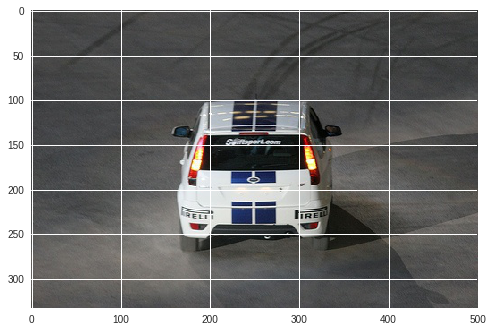

In [0]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from keras_retinanet.utils.visualization import draw_box, draw_caption
from keras_retinanet.utils.colors import label_color
import cv2
import os
labels_to_names = {0: 'aeroplane',1: 'bicycle',2: 'bird',3: 'boat',4:'bottle',5:'bus',6:'car',7:'cat',8:'chair',
                   9:'cow',10:'diningtable',11: 'dog',12:'horse',13:'motorbike',14:'person',15:'pottedplant',
                   16:'sheep',17:'sofa',18:'train',19:'tvmonitor'}
image=mpimg.imread('000012.jpg')
imgplot = plt.imshow(image) #show 000012.jpg Image
plt.show()

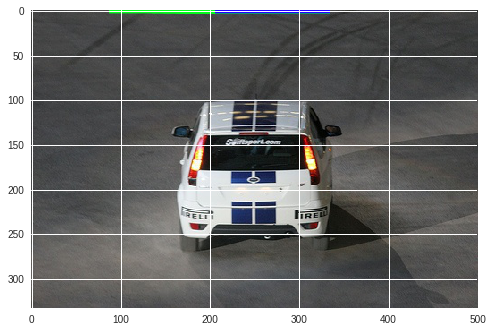

In [0]:
# Object Detection Logic

boxes, scores, labels = prediction_model.predict_on_batch(np.expand_dims(image, axis=0))

# visualize detections
for box, score, label in zip(boxes[0], scores[0], labels[0]):
    # scores are sorted so we can break
    if score < 0.5:
        break
        
    color = label_color(label)
    
    b = box.astype(int)
    thickness=2
    cv2.rectangle(image, (b[0], b[1]), (b[2], b[3]), color, thickness, cv2.LINE_AA)
    
    caption = "{} {:.3f}".format(labels_to_names[label], score)
    draw_caption(image, b, caption)
    
plt.imshow(image)
plt.show()

#####TestCase of well trained Retinanet Model

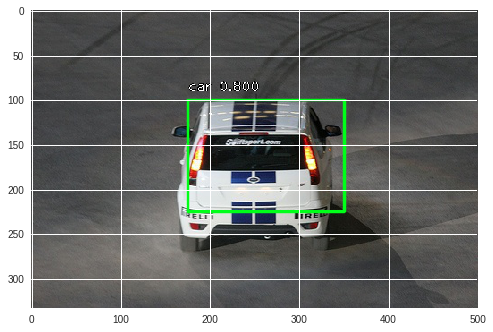

In [0]:
#Boxes,scores,labels will be more accurate after training retinanet model for more epochs
box_t=np.array([175,100,350,225])
score_t=0.80
label_t=6
color_t = label_color(label_t)
    
b_t = box_t.astype(int)
thickness=2
cv2.rectangle(image, (b_t[0], b_t[1]), (b_t[2], b_t[3]), color_t, thickness, cv2.LINE_AA)
    
caption = "{} {:.3f}".format(labels_to_names[label_t], score_t)
draw_caption(image, b_t, caption)
    
plt.imshow(image)
plt.show()
